##  **PNEUMONIA IDENTIFICATION FROM X-RAY IMAGES**
### *BIG DATA ENGINEERING FINAL PROJECT*

### *Juan Carlos Carrasco, Guillermo Chumaceiro, Marina Herrero y Aida Pinacho.*

**The aim of this project is to develop a model capable of effectively classify torax x-ray images in two groups: belonging to a patient with pneumonia, or belonging to a heallthy / normal patient. Additionally, the model needs to be created by making use of pyspark (using high-level interface) as well as including Analytics Zoo.**

##**1. INTRODUCTION**

###**1.1 Pneumonia**

Pneumonia is an illness that causes the air sacs in your lungs to become inflamed (alveoli). The air sacs may get clogged with fluid or pus, resulting in symptoms including coughing, fever, chills, and difficulty breathing.

Pneumonia symptoms can range from being so little that you don't even notice them to being so severe that you need to be admitted to the hospital. The type of bacteria that causes pneumonia, your age, and your overall health all influence how your body reacts.

###**1.2 Symptoms**

The following are some of the indicators and symptoms of pneumonia:

-Greenish, yellow, or even crimson mucus can be produced by coughing.

-Fever, perspiration, and shivering chills are all symptoms of a fever.

-Breathing problems.

-Breathing that is quick and shallow.

-Sharp or piercing chest discomfort that worsens when you cough or breathe deeply.

-Appetite loss, poor energy, and lethargy.

-Especially with little children, nausea and vomiting are common.

-Confusion, especially among the elderly.

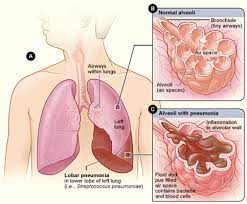

*Figure 1: Graphic representation of penumonia*

The most frequent type of pneumonia, bacterial pneumonia, is more dangerous than other varieties, with symptoms that need of medical attention. Bacterial pneumonia symptoms might appear gradually or unexpectedly. Fever can reach temperatures of 40 degrees Celsius, along with perspiration, rapid breathing, and elevated heart rate. Because of the shortage of oxygen in the blood, lips and nailbeds may appear blue. It's possible that a patient's mental state is muddled or delusional.



###**1.3 Diagnoses**

Because the symptoms of pneumonia vary so much and are frequently extremely similar to those of a cold or influenza, it can be difficult to diagnose. Your doctor will ask questions about your medical history, perform a physical exam, and order tests to confirm pneumonia and try to identify the bacteria that is causing the sickness. If they believe you have pneumonia, he or she will likely suggest several tests to confirm the diagnosis and learn more about your illness. These may include the following:

**-**Blood tests will be performed to confirm the infection and to identify the germ that is causing your sickness.

**-**Pulse oximetry is a test that measures the amount of oxygen in your blood.Pneumonia can make it difficult for your lungs to get enough oxygen into your circulation. 

**-**To find the source of the illness, a sputum test is performed on a sample of mucus (sputum) collected after a deep cough.

**-**If you're a high-risk patient due to your age or overall health, or if you're in the hospital, your doctor may order extra tests, such as a CT scan of your chest to obtain a clearer image of your lungs and search for abscesses or other issues.

**-**The quantity of oxygen in a blood sample obtained from an artery, generally in your wrist, is measured using an arterial blood gas test. This method is more precise than pulse oximetry.

**-**Pleural fluid culture is a technique for analyzing and identifying bacteria that cause pneumonia by removing a tiny volume of fluid from around the tissues that surround the lung.

**-**Bronchoscopy is a technique that allows doctors to examine into the airways of the lungs. Whether you're in the hospital and your therapy isn't working, physicians may want to check to see if your airways are being affected by anything else, such as a blockage. They could also obtain fluid samples or a lung biopsy.

**-**A chest X-ray will be used to determine the location and severity of the inflammation in your lungs.



###**1.4 AI in Radiology**

In image-recognition tasks, artificial intelligence (AI) systems, particularly deep learning, have made significant progress. In the field of medical image analysis, methods ranging from convolutional neural networks to variational autoencoders have found a wide range of applications, driving it ahead at a quick pace. In the past, trained clinicians visually analyzed medical pictures for the identification, characterization, and monitoring of illnesses in radiology practice. Artificial intelligence is particularly good at spotting complicated patterns in imaging data and delivering quantitative rather than qualitative judgments of radiographic qualities.

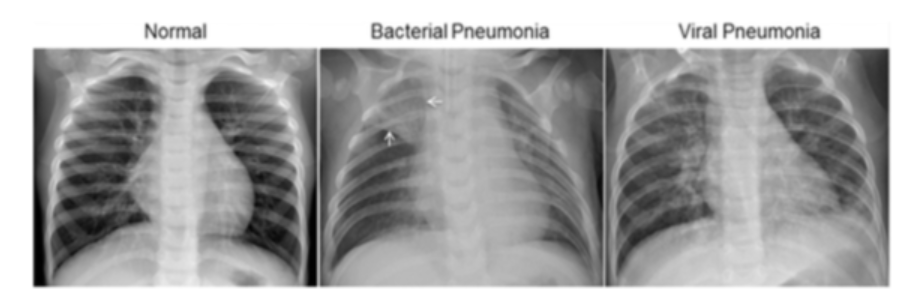

*Figure 2. The picture of a typical chest X-ray (left panel) shows clean lungs with no spots of aberrant opacification. Bacterial pneumonia (center) is characterized by a focused lobar consolidation, as shown here in the right upper lobe (white arrows), whereas viral pneumonia (right) is characterized by a more widespread "interstitial" pattern in both lungs.*

##**2. DATASET**

###**2.1 Description**

The [dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) is divided into three folders (train, test, and val) with subfolders for each picture type (Pneumonia/Normal). There are 5,863 X-Ray pictures (JPEG) in total, divided into two groups (Pneumonia/Normal).

Anterior-posterior chest X-ray pictures were chosen from retrospective cohorts of children patients aged one to five years old at Guangzhou Women and Children's Medical Center in Guangzhou. All chest X-ray imaging was done as part of the patients' regular medical treatment.

To analyze chest x-ray pictures, all chest radiographs were first reviewed for quality control, with any scans that were low quality or illegible being removed. After that, the diagnoses for the photographs were rated by two experts before being approved for use in the AI system. A third expert evaluated the assessment set to make sure there were no grading problems.

###**2.2 Importing and unzipping Dataset**

The data will be downloaded using the kaggle API.

In [ ]:
# Connecting to Google Dirve
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downloading the data to the Google Colab

import zipfile
import os

# Coping the kaggle API to the Google Colab
!cp "/content/drive/MyDrive/BigData/FINAL_PROJECT/kaggle.json" "/content"
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Downloading the data
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzziping the data and storing into /tmp
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

 99% 2.28G/2.29G [00:24<00:00, 182MB/s]
100% 2.29G/2.29G [00:24<00:00, 101MB/s]


##**3. Importing libraries**

Importing all necessary libraries for the project

In [ ]:
# Importing libraries
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, experimental
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.data import Dataset
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

##**4. Execution of the model in TensorFlow Keras**

In order to perform the analysis, the first step is to implement the model in Keras, in order to export the model to Analytics.zoo Orcas knowing that, indeed, the model works.

###**4.1 Creating the DataFrames**

In [ ]:
# Defining the paths of the directories that were unzipped
train_normal_dir = '/tmp/chest_xray/train/NORMAL/'
train_pneu_dir = '/tmp/chest_xray/train/PNEUMONIA/'

test_normal_dir = '/tmp/chest_xray/test/NORMAL/'
test_pneu_dir = '/tmp/chest_xray/test/PNEUMONIA/'

val_normal_dir = '/tmp/chest_xray/val/NORMAL/'
val_pneu_dir = '/tmp/chest_xray/val/PNEUMONIA/'


# Picking only the jpeg files (there are some other files starting with "._")
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# Make three lists with jpegs and labels, for train, test, and validation
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


#Shuffle in order to avoid having the jpegs organized (as the pneumonia jpegs will be all at first, and then all the normals)
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# Create the dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

###**4.2 Visualizing the data**

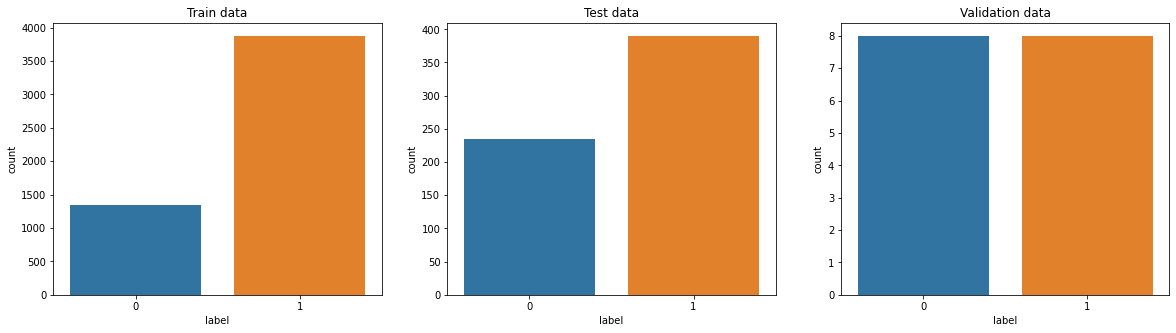

In [ ]:
# Checking the number of images classified as pneumonia and normal within all three dataframes. Looking for imbalance.
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['label'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['label'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['label'])
plt.title('Validation data')

plt.show()

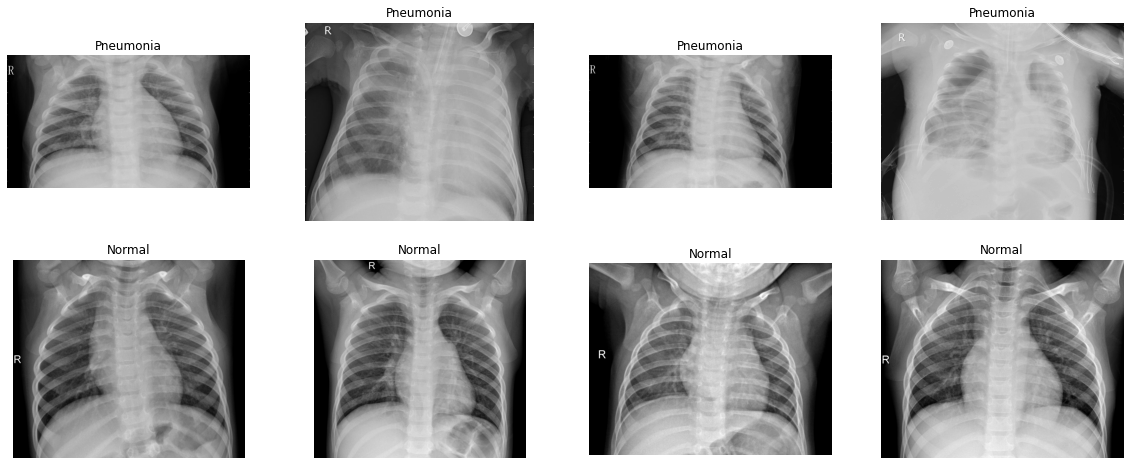

In [ ]:
# Visualizing the images. Here it can be seen that each image has different dimensions, and it needed to be normalised.
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

###**4.3 Preprocessing**

In [ ]:
# Now, two functions are going to be defined for preprocessing of the images, in order to allow them to be imputs for tensorflow

# Making a function that change the image dimensions to a predefined ones, turning into gray-scale, normalizing, and adding a channel
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (196,196,1))
    
    return img

# Making a function that picks each image, applies previous function, and introduces it into a numpy array. Making another array with the labels
def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [ ]:
# Applying functions to datasets (train, test y validation)
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 196, 196, 1), Labels shape: (5216,)
Test data shape: (624, 196, 196, 1), Labels shape: (624,)
Validation data shape: (16, 196, 196, 1), Labels shape: (16,)


In [ ]:
# Applying some changes to the training images in order to make a more robust model and avoid overfitting
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

datagen.fit(X_train)

In [ ]:
# Categorical classification have showed better results in this case, even if it looks better to apply a binary classification
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

##**4.4 Making the model**

Performing a sequential model, starting with 2 convolutional networks of kernel size (7,7) and max pooling with pool size (3,3), followed by 2 convolutional networks of kernel size (5,5) and same pool size and finalized by several repeating sets of 2 convolutional networks of kernel size (3,3) with max pooling and pool size (2,2)

In [ ]:
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(196, 196, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=6)
history = model.fit(datagen.flow(X_train,y_train, batch_size=4), validation_data=(X_test, y_test), epochs = 10, verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})

Epoch 1/10
1304/1304 [==============================] - 651s 498ms/step - loss: 0.6783 - accuracy: 0.5006 - val_loss: 0.4085 - val_accuracy: 0.8109
Epoch 2/10
1304/1304 [==============================] - 663s 508ms/step - loss: 0.3282 - accuracy: 0.8284 - val_loss: 0.3345 - val_accuracy: 0.8798
Epoch 3/10
1304/1304 [==============================] - 665s 510ms/step - loss: 0.2882 - accuracy: 0.8535 - val_loss: 0.4240 - val_accuracy: 0.8269
Epoch 4/10
1304/1304 [==============================] - 658s 505ms/step - loss: 0.2542 - accuracy: 0.8708 - val_loss: 0.3000 - val_accuracy: 0.9087
Epoch 5/10
1304/1304 [==============================] - 660s 506ms/step - loss: 0.2341 - accuracy: 0.8890 - val_loss: 0.3113 - val_accuracy: 0.8990
Epoch 6/10
1304/1304 [==============================] - 658s 504ms/step - loss: 0.2101 - accuracy: 0.9001 - val_loss: 0.3049 - val_accuracy: 0.8974
Epoch 7/10
1304/1304 [==============================] - 667s 511ms/step - loss: 0.2016 - accuracy: 0.9034 - val_

##**4.4 Evaluation**

In this part, the evolution of the model along the modeling phase will be plotted.

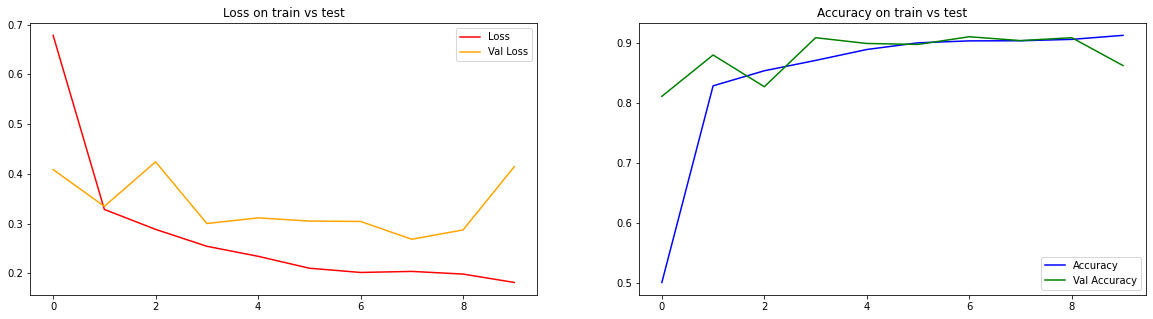

In [ ]:
plt.figure(figsize=(20,5))

# ploting loss y val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plotting accuracy y val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

And now, the confusion matrix

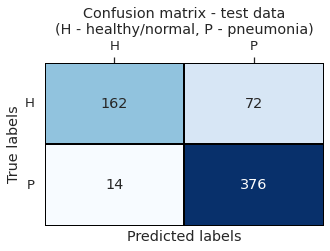

Classification report on test data
              precision    recall  f1-score   support

           0       0.92      0.69      0.79       234
           1       0.84      0.96      0.90       390

    accuracy                           0.86       624
   macro avg       0.88      0.83      0.84       624
weighted avg       0.87      0.86      0.86       624



In [ ]:
# Performing our prediction over the test, and obtaining the real value stored in the labels
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

# Calculating the confussion matrix and the classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# Plotting the confussion matrix as a heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

# Checking the classification report
print('Classification report on test data')
print(clas_r)

For the validation set, as only 8 individuals of each class were present, we will use to display an example of how the model works

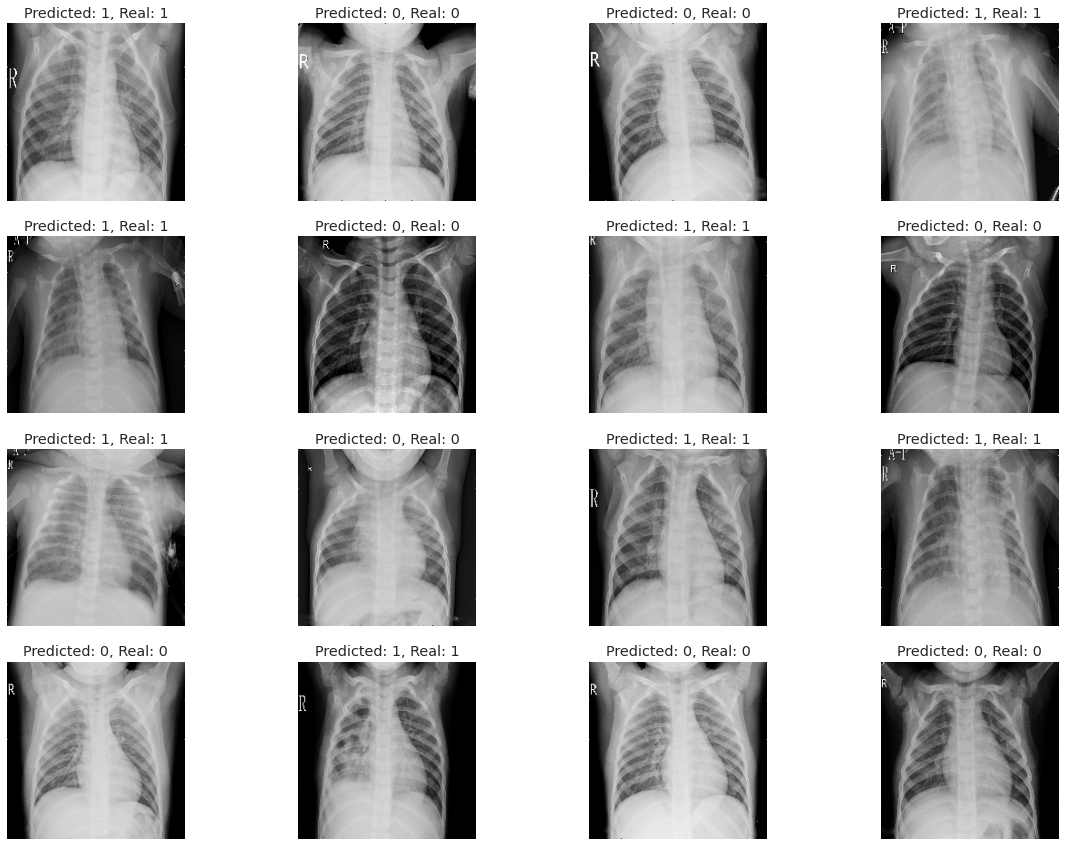

In [ ]:
y_val_hat = model.predict(X_val, batch_size=4)
y_val_hat = np.argmax(y_val_hat, axis=1)
y_val = np.argmax(y_val, axis=1)

# Looking at some Examples
plt.figure(figsize=(20,15))
for i,x in enumerate(X_val):
    plt.subplot(4,4,i+1)
    plt.imshow(x.reshape(196, 196), cmap='gray')
    plt.axis('off')
    plt.title('Predicted: {}, Real: {}'.format(y_val_hat[i], y_val[i]))

##**5. Execution of the model using Spark and Analytics.zoo**

Now that the model has proven to work, it will be applied to Spark using orcas in order for it to be scalable

###**5.1 Installing necessary items**

Despite of having already imported the needed libraries, the environment needs to be setted up or using Orcas and Spark.

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


In [ ]:
# Install latest pre-release version of Analytics Zoo
# Installing Analytics Zoo from pip will automatically install pyspark, bigdl, and their dependencies.

!pip install --pre --upgrade analytics-zoo[ray]

     |████████████████████████████████| 194.7 MB 54 kB/s 
     |████████████████████████████████| 218.4 MB 55 kB/s 
     |████████████████████████████████| 114.0 MB 25 kB/s 
     |████████████████████████████████| 1.3 MB 41.7 MB/s 
     |████████████████████████████████| 47.5 MB 130 kB/s 
     |████████████████████████████████| 65 kB 3.6 MB/s 
     |████████████████████████████████| 62 kB 695 kB/s 
     |████████████████████████████████| 271 kB 55.1 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 197 kB 38.1 MB/s 
     |████████████████████████████████| 82 kB 218 kB/s 
     |████████████████████████████████| 173 kB 44.0 MB/s 
     |████████████████████████████████| 202 kB 44.5 MB/s 
     |████████████████████████████████| 128 kB 54.4 MB/s 
     |████████████████████████████████| 3.0 MB 48.1 MB/s 
     |████████████████████████████████| 58 kB 4.6 MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.6-py2.py3-none-any.whl size=2188

In [ ]:
# import necesary libraries and modules
from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext

In [ ]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

init_orca_context(cluster_mode="local", cores=2)

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.13.1-SNAPSHOT-spark_2.4.6-0.12.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/lib/bigdl-0.13.1-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
2022-02-10 14:03:44 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


cls.getname: com.intel.analytics.bigdl.python.api.Sample
BigDLBasePickler registering: bigdl.util.common  Sample
cls.getname: com.intel.analytics.bigdl.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.util.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.python.api.JTensor
BigDLBasePickler registering: bigdl.util.common  JTensor
cls.getname: com.intel.analytics.bigdl.python.api.JActivity
BigDLBasePickler registering: bigdl.util.common  JActivity
Successfully got a SparkContext



User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
  

<SparkContext master=local[2] appName=pyspark-shell>

###**5.2 Defining the function of the model**

This model has already proven to work in keras, so it will be introduced in Orcas knowing that it already works

In [ ]:
def model_creator(config):
  model = Sequential()

  model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(196, 196, 1)))
  model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3)))

  model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
  model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3)))

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))

  experimental.preprocessing.RandomRotation((-0.1, 0.1)),
  experimental.preprocessing.RandomZoom((0.05, 0.15))

  optimizer = Adam(lr=0.0001, decay=1e-5)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,
           metrics=['accuracy', 
           TruePositives(name='TP'), 
           FalsePositives(name='FP'), 
           TrueNegatives(name='TN'),
           FalseNegatives(name='FN'),
           ])

  return model

###**5.2 Defining the function for introducing the data**

The data_creator for the train and validation datasets will be created. All the steps previously used will be repeated in order to be able to split both models presented in this notebook in an easy way.

#### 5.2.1 Training data

In [ ]:
def train_data_creator(config, batch_size):
  
  # definiendo las rutas a los archivos extraidos
  train_normal_dir = '/tmp/chest_xray/train/NORMAL/'
  train_pneu_dir = '/tmp/chest_xray/train/PNEUMONIA/'

  test_normal_dir = '/tmp/chest_xray/test/NORMAL/'
  test_pneu_dir = '/tmp/chest_xray/test/PNEUMONIA/'

  val_normal_dir = '/tmp/chest_xray/val/NORMAL/'
  val_pneu_dir = '/tmp/chest_xray/val/PNEUMONIA/'


  # Cogiendo los que tengan "jpeg" (hay algunos que empiezan con "._")
  train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
  train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

  test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
  test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

  val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
  val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


  # Crear lista con las imagenes y las labels
  train_list = []
  test_list = []
  val_list = []

  for x in train_normal_cases:
    train_list.append([x, 0])
    
  for x in train_pneu_cases:
    train_list.append([x, 1])
    
  for x in test_normal_cases:
    test_list.append([x, 0])
    
  for x in test_pneu_cases:
    test_list.append([x, 1])
    
  for x in val_normal_cases:
    val_list.append([x, 0])
    
  for x in val_pneu_cases:
    val_list.append([x, 1])


  # Barajar para evitar que las imagenes se encuentren ordenadas (primero pneumonia y luego normales)
  rn.shuffle(train_list)
  rn.shuffle(test_list)
  rn.shuffle(val_list)


  # Crear los dataframes
  train_df = pd.DataFrame(train_list, columns=['image', 'label'])
  test_df = pd.DataFrame(test_list, columns=['image', 'label'])
  val_df = pd.DataFrame(val_list, columns=['image', 'label'])
  


  # Ahora vamos a definir las funciones para el preprocesamiento de las imagenes, y prepararlo todo para poder darselo a tensorflow luego

  # Primero cargar la imagen, hacerla de un tamaño determinado, ponerla en escala de grises, normalizar, y ponerla en la forma que acepta tensorflow
  def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (196,196,1))
    
    return img

  # Después, ir cogiendo cada imagen, e irla transformando con la función anterior, para luego introducirla en un array. En otro array, se introduciran las labels
  def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)



  # Aplicando las funciones a cada dataset (train, test y validation)
  X_train, y_train = compose_dataset(train_df)
  X_test, y_test = compose_dataset(test_df)
  X_val, y_val = compose_dataset(val_df)


  # Para evitar overfitting, le metemos algunas transformaciones a nuestro dataset de entrenamiento
  # Cabe destacar que cambiar la orientación de las imagenes vertical u horizontalmente carece de sentido en este contexto
  datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
  )

  # Aplicando las transformaciones anteriormente mencionadas
  datagen.fit(X_train)

  # Aunque queramos una clasificación binaria, hemos visto que la clasificación binaria es peor que la categórica en este caso
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  y_val = to_categorical(y_val)


  dataset = Dataset.from_tensor_slices((X_train, y_train))

  dataset = dataset.batch(batch_size)

  return dataset

#### 5.2.2 Validation Data

In [ ]:
# Defining the data_creator for the validation dataset. All steps used in the working keras model will be applied.

def val_data_creator(config, batch_size):
  # definiendo las rutas a los archivos extraidos
  train_normal_dir = '/tmp/chest_xray/train/NORMAL/'
  train_pneu_dir = '/tmp/chest_xray/train/PNEUMONIA/'

  test_normal_dir = '/tmp/chest_xray/test/NORMAL/'
  test_pneu_dir = '/tmp/chest_xray/test/PNEUMONIA/'

  val_normal_dir = '/tmp/chest_xray/val/NORMAL/'
  val_pneu_dir = '/tmp/chest_xray/val/PNEUMONIA/'


  # Cogiendo los que tengan "jpeg" (hay algunos que empiezan con "._")
  train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
  train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

  test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
  test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

  val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
  val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


  # Crear lista con las imagenes y las labels
  train_list = []
  test_list = []
  val_list = []

  for x in train_normal_cases:
    train_list.append([x, 0])
    
  for x in train_pneu_cases:
    train_list.append([x, 1])
    
  for x in test_normal_cases:
    test_list.append([x, 0])
    
  for x in test_pneu_cases:
    test_list.append([x, 1])
    
  for x in val_normal_cases:
    val_list.append([x, 0])
    
  for x in val_pneu_cases:
    val_list.append([x, 1])


  # Barajar para evitar que las imagenes se encuentren ordenadas (primero pneumonia y luego normales)
  rn.shuffle(train_list)
  rn.shuffle(test_list)
  rn.shuffle(val_list)


  # Crear los dataframes
  train_df = pd.DataFrame(train_list, columns=['image', 'label'])
  test_df = pd.DataFrame(test_list, columns=['image', 'label'])
  val_df = pd.DataFrame(val_list, columns=['image', 'label'])
  


  # Ahora vamos a definir las funciones para el preprocesamiento de las imagenes, y prepararlo todo para poder darselo a tensorflow luego

  # Primero cargar la imagen, hacerla de un tamaño determinado, ponerla en escala de grises, normalizar, y ponerla en la forma que acepta tensorflow
  def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (196,196,1))
    
    return img

  # Después, ir cogiendo cada imagen, e irla transformando con la función anterior, para luego introducirla en un array. En otro array, se introduciran las labels
  def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)



  # Aplicando las funciones a cada dataset (train, test y validation)
  X_train, y_train = compose_dataset(train_df)
  X_test, y_test = compose_dataset(test_df)
  X_val, y_val = compose_dataset(val_df)


  # Para evitar overfitting, le metemos algunas transformaciones a nuestro dataset de entrenamiento
  # Cabe destacar que cambiar la orientación de las imagenes vertical u horizontalmente carece de sentido en este contexto
  datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
  )

  # Aplicando las transformaciones anteriormente mencionadas
  datagen.fit(X_train)

  # Aunque queramos una clasificación binaria, hemos visto que la clasificación binaria es peor que la categórica en este caso
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  y_val = to_categorical(y_val)


  dataset = Dataset.from_tensor_slices((X_test, y_test))
  dataset = dataset.batch(batch_size)

  return dataset

###**5.3 Aplying the model to the estimator form Orcas**

In [ ]:
from zoo.orca.learn.tf2 import Estimator

est = Estimator.from_keras(model_creator = model_creator)

2022-02-10 14:03:53,336	INFO services.py:1174 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2022-02-10_14-03-52_544432_68/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-02-10_14-03-52_544432_68/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2022-02-10_14-03-52_544432_68', 'metrics_export_port': 62836, 'node_id': 'f342c3a08cf13ce39091a6112e5630a6f098e8cde87712993b4c6530'}


(pid=2326) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/zoo/orca/learn/tf2/tf_runner.py:317: _CollectiveAllReduceStrategyExperimental.__init__ (from tensorflow.python.distribute.collective_all_reduce_strategy) is deprecated and will be removed in a future version.
(pid=2326) Instructions for updating:
(pid=2326) use distribute.MultiWorkerMirroredStrategy instead
(pid=2326) 2022-02-10 14:04:08.751856: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=2326) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(pid=2326)   super(Adam, self).__init__(name, **kwargs)


###**5.4 Fitting the model**

In [ ]:
batch_size = 4
callback = EarlyStopping(
    monitor="loss",
    patience=6,
    verbose=2,
    restore_best_weights=True)

stats = est.fit(train_data_creator, 
                callbacks=callback,
                epochs=10,
                batch_size=batch_size,
                verbose=2,
                validation_data=val_data_creator)

(pid=2326) tcmalloc: large alloc 1603026944 bytes == 0x55ce78c26000 @  0x7f81b5c8f1e7 0x7f81af78946e 0x7f81af7d9c7b 0x7f81af7dce83 0x7f81af7dd07b 0x7f81af87e761 0x55ce0cf91390 0x55ce0cf91120 0x55ce0d005679 0x55ce0d0001c0 0x55ce0cf92aba 0x55ce0d000eae 0x55ce0d00066e 0x55ce0cf92aba 0x55ce0d000eae 0x55ce0d00002f 0x55ce0cf92aba 0x55ce0d001cd4 0x55ce0d00002f 0x55ce0ced1e2b 0x55ce0d002633 0x55ce0d00066e 0x55ce0ced1e2b 0x7f81b2b08e1f 0x7f81b2b70a9a 0x7f81b2b08e1f 0x7f81b2ba4bbb 0x7f81b2b10e43 0x7f81b2c650b6 0x7f81b2bf0732 0x7f81b2c9a6d8
(pid=2326) tcmalloc: large alloc 1603026944 bytes == 0x55ceda462000 @  0x7f81b5c8f1e7 0x7f81af78946e 0x7f81af7d9c7b 0x7f81af7dce83 0x7f81af7dd07b 0x7f81af87e761 0x55ce0cf91390 0x55ce0cf91120 0x55ce0d005679 0x55ce0d0001c0 0x55ce0cf92aba 0x55ce0d000eae 0x55ce0d00066e 0x55ce0cf92aba 0x55ce0d000eae 0x55ce0d00002f 0x55ce0cf92aba 0x55ce0d001cd4 0x55ce0d00002f 0x55ce0ced1e2b 0x55ce0d002633 0x55ce0d00066e 0x55ce0ced1e2b 0x7f81b2b08e1f 0x7f81b2b70a9a 0x7f81b2b08e1f 0x7

(pid=2326) Epoch 1/10


(pid=2326) 2022-02-10 14:20:20.720010: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
(pid=2326) op: "TensorSliceDataset"
(pid=2326) input: "Placeholder/_0"
(pid=2326) input: "Placeholder/_1"
(pid=2326) attr {
(pid=2326)   key: "Toutput_types"
(pid=2326)   value {
(pid=2326)     list {
(pid=2326)       type: DT_DOUBLE
(pid=2326)       type: DT_FLOAT
(pid=2326)     }
(pid=2326)   }
(pid=2326) }
(pid=2326) attr {
(pid=2326)   key: "_cardinality"
(pid=2326)   value {
(pid=2326)     i: 624
(pid=2326)   }
(pid=2326) }
(pid=2326) attr {
(pid=2326)   key: "is_files"
(pid=2326)   value {
(pid=2326)     b: false
(pid=2326)   }
(pid=2326) }
(pid=2326) attr {
(pid=2326)   key: "metadata"
(pid=2326)   value {
(pid=2326)     s: "\n\024TensorSliceDataset:2"
(pid=2326)   }
(pid=2326) }
(pid=23

(pid=2326) 1304/1304 - 731s - loss: 0.3168 - accuracy: 0.8606 - TP: 4489.0000 - FP: 727.0000 - TN: 4489.0000 - FN: 727.0000 - val_loss: 0.7965 - val_accuracy: 0.7099 - val_TP: 443.0000 - val_FP: 181.0000 - val_TN: 443.0000 - val_FN: 181.0000 - 731s/epoch - 561ms/step
(pid=2326) Epoch 2/10


(pid=2326) 2022-02-10 14:32:47.955461: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
(pid=2326) 2022-02-10 14:33:05.827650: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1603022848 exceeds 10% of free system memory.


(pid=2326) 1304/1304 - 732s - loss: 0.1164 - accuracy: 0.9572 - TP: 4993.0000 - FP: 223.0000 - TN: 4993.0000 - FN: 223.0000 - val_loss: 0.8532 - val_accuracy: 0.7740 - val_TP: 483.0000 - val_FP: 141.0000 - val_TN: 483.0000 - val_FN: 141.0000 - 732s/epoch - 561ms/step
(pid=2326) Epoch 3/10


(pid=2326) 2022-02-10 14:45:00.184053: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


(pid=2326) 1304/1304 - 732s - loss: 0.0843 - accuracy: 0.9701 - TP: 5060.0000 - FP: 156.0000 - TN: 5060.0000 - FN: 156.0000 - val_loss: 0.7968 - val_accuracy: 0.7804 - val_TP: 487.0000 - val_FP: 137.0000 - val_TN: 487.0000 - val_FN: 137.0000 - 732s/epoch - 561ms/step
(pid=2326) Epoch 4/10


(pid=2326) 2022-02-10 14:56:57.886854: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


(pid=2326) 1304/1304 - 716s - loss: 0.0719 - accuracy: 0.9755 - TP: 5088.0000 - FP: 128.0000 - TN: 5088.0000 - FN: 128.0000 - val_loss: 1.2919 - val_accuracy: 0.7596 - val_TP: 474.0000 - val_FP: 150.0000 - val_TN: 474.0000 - val_FN: 150.0000 - 716s/epoch - 549ms/step
(pid=2326) Epoch 5/10


(pid=2326) 2022-02-10 15:09:17.954520: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


(pid=2326) 1304/1304 - 714s - loss: 0.0593 - accuracy: 0.9780 - TP: 5101.0000 - FP: 115.0000 - TN: 5101.0000 - FN: 115.0000 - val_loss: 1.1659 - val_accuracy: 0.7740 - val_TP: 483.0000 - val_FP: 141.0000 - val_TN: 483.0000 - val_FN: 141.0000 - 714s/epoch - 548ms/step
(pid=2326) Epoch 6/10


(pid=2326) 2022-02-10 15:21:43.399596: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


(pid=2326) 1304/1304 - 718s - loss: 0.0526 - accuracy: 0.9808 - TP: 5116.0000 - FP: 100.0000 - TN: 5116.0000 - FN: 100.0000 - val_loss: 1.1405 - val_accuracy: 0.7724 - val_TP: 482.0000 - val_FP: 142.0000 - val_TN: 482.0000 - val_FN: 142.0000 - 718s/epoch - 550ms/step
(pid=2326) Epoch 7/10


(pid=2326) 2022-02-10 15:34:07.562540: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


(pid=2326) 1304/1304 - 720s - loss: 0.0452 - accuracy: 0.9826 - TP: 5125.0000 - FP: 91.0000 - TN: 5125.0000 - FN: 91.0000 - val_loss: 1.5190 - val_accuracy: 0.7500 - val_TP: 468.0000 - val_FP: 156.0000 - val_TN: 468.0000 - val_FN: 156.0000 - 720s/epoch - 552ms/step
(pid=2326) Epoch 8/10


(pid=2326) 2022-02-10 15:46:30.218315: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


(pid=2326) 1304/1304 - 721s - loss: 0.0403 - accuracy: 0.9833 - TP: 5129.0000 - FP: 87.0000 - TN: 5129.0000 - FN: 87.0000 - val_loss: 1.5561 - val_accuracy: 0.7596 - val_TP: 474.0000 - val_FP: 150.0000 - val_TN: 474.0000 - val_FN: 150.0000 - 721s/epoch - 553ms/step
(pid=2326) Epoch 9/10


(pid=2326) 2022-02-10 15:58:51.266002: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


(pid=2326) 1304/1304 - 720s - loss: 0.0354 - accuracy: 0.9850 - TP: 5138.0000 - FP: 78.0000 - TN: 5138.0000 - FN: 78.0000 - val_loss: 1.5443 - val_accuracy: 0.7516 - val_TP: 469.0000 - val_FP: 155.0000 - val_TN: 469.0000 - val_FN: 155.0000 - 720s/epoch - 552ms/step
(pid=2326) Epoch 10/10


(pid=2326) 2022-02-10 16:11:15.668224: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


(pid=2326) 1304/1304 - 722s - loss: 0.0311 - accuracy: 0.9893 - TP: 5160.0000 - FP: 56.0000 - TN: 5160.0000 - FN: 56.0000 - val_loss: 1.6472 - val_accuracy: 0.7516 - val_TP: 469.0000 - val_FP: 155.0000 - val_TN: 469.0000 - val_FN: 155.0000 - 722s/epoch - 554ms/step


###**5.5 Evaluating the model**

In [ ]:
stats = est.evaluate(val_data_creator, batch_size=batch_size)
est.shutdown()
stop_orca_context()
print(stats)

(pid=2326) 2022-02-10 16:14:33.501640: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
(pid=2326) op: "TensorSliceDataset"
(pid=2326) input: "Placeholder/_0"
(pid=2326) input: "Placeholder/_1"
(pid=2326) attr {
(pid=2326)   key: "Toutput_types"
(pid=2326)   value {
(pid=2326)     list {
(pid=2326)       type: DT_DOUBLE
(pid=2326)       type: DT_FLOAT
(pid=2326)     }
(pid=2326)   }
(pid=2326) }
(pid=2326) attr {
(pid=2326)   key: "_cardinality"
(pid=2326)   value {
(pid=2326)     i: 624
(pid=2326)   }
(pid=2326) }
(pid=2326) attr {
(pid=2326)   key: "is_files"
(pid=2326)   value {
(pid=2326)     b: false
(pid=2326)   }
(pid=2326) }
(pid=2326) attr {
(pid=2326)   key: "metadata"
(pid=2326)   value {
(pid=2326)     s: "\n\026TensorSliceDataset:171"
(pid=2326)   }
(pid=2326) }
(pid=

156/156 [==============================] - 24s 150ms/step - loss: 1.6472 - accuracy: 0.7516 - TP: 469.0000 - FP: 155.0000 - TN: 469.0000 - FN: 155.0000
Stopping orca context
{'validation_loss': 1.647175908088684, 'validation_accuracy': 0.7516025900840759, 'validation_TP': 469.0, 'validation_FP': 155.0, 'validation_TN': 469.0, 'validation_FN': 155.0}


##**CONCLUSION**



Medical imaging has always been an important part of medical care, from the early days of X-ray imaging in the 1890s to more recent developments in CT, MRI, and PET scanning. The identification of minute changes in tissue densities is now possible because to recent developments in imaging technology in terms of quality, sensitivity, and resolution. In other circumstances, even a trained eye and even classic AI approaches used in the clinic struggle to detect such discrepancies. These approaches aren't quite up to the level of sophistication found in imaging devices, but they provide another another reason to push on with this paradigm shift toward more powerful AI tools.

Furthermore, unlike previous approaches based on predetermined characteristics, we discover that deep learning algorithms scale with data, meaning that as more data is collected every day and research efforts continue, we should anticipate to observe relative increases in performance. All of these advancements promise better accuracy and a reduction in the amount of time-consuming and effort-intensive everyday chores.